In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')
%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

Bibliotecas importadas com sucesso!


In [ ]:
data_path = 'data/'

path_train_file = os.path.join(data_path, 'train.csv')
path_test_file = os.path.join(data_path, 'test.csv')
path_submission_example_file = os.path.join(data_path, 'gender_submission.csv')

In [ ]:
try:
    train_df_raw = pd.read_csv(path_train_file)
    test_df_raw = pd.read_csv(path_test_file)

    print("Dados originais carregados (train_df_raw, test_df_raw).")
    print(f"Verificando se o arquivo de treino foi encontrado em: {path_train_file} -> {'Encontrado' if os.path.exists(path_train_file) else 'NÃO ENCONTRADO'}")
    print(f"Verificando se o arquivo de teste foi encontrado em: {path_test_file} -> {'Encontrado' if os.path.exists(path_test_file) else 'NÃO ENCONTRADO'}")

    print("\nDimensões train_df_raw:", train_df_raw.shape)
    print("Dimensões test_df_raw:", test_df_raw.shape)
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivos: {e}")
    print("Verifique se a pasta 'data' existe no mesmo diretório do seu notebook/script e contém os arquivos CSV.")

Dados originais carregados (train_df_raw, test_df_raw).
Verificando se o arquivo de treino foi encontrado em: data/train.csv -> Encontrado
Verificando se o arquivo de teste foi encontrado em: data/test.csv -> Encontrado

Dimensões train_df_raw: (891, 12)
Dimensões test_df_raw: (418, 11)


In [ ]:

train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

print("Cópias 'train_df' e 'test_df' criadas.")

Cópias 'train_df' e 'test_df' criadas.


In [ ]:

passenger_id_test_v2 = test_df['PassengerId'].copy() 
print("PassengerId do teste (passenger_id_test_v2) guardado.")


PassengerId do teste (passenger_id_test_v2) guardado.


### Simplificação de Titulos

In [ ]:
print("\nExtraindo 'Title'...")
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_replacements = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Capt": "Other", "Col": "Other", "Major": "Other", "Rev": "Other",
    "Jonkheer": "Other", "Don": "Other", "Dona": "Other", "Lady": "Other",
    "Countess":"Other", "Sir": "Other", "Dr": "Other"
}
train_df['Title'] = train_df['Title'].replace(title_replacements)
test_df['Title'] = test_df['Title'].replace(title_replacements)

main_titles = ['Mr', 'Miss', 'Mrs', 'Master']
train_df['Title'] = train_df['Title'].apply(lambda x: x if x in main_titles else 'Other')
test_df['Title'] = test_df['Title'].apply(lambda x: x if x in main_titles else 'Other')


print(f"Títulos únicos em train_df após simplificação: {train_df['Title'].unique()}")
print(f"Títulos únicos em test_df após simplificação: {test_df['Title'].unique()}")


Extraindo 'Title'...
Títulos únicos em train_df após simplificação: ['Mr' 'Mrs' 'Miss' 'Master' 'Other']
Títulos únicos em test_df após simplificação: ['Mr' 'Mrs' 'Miss' 'Master' 'Other']


### Extração do Deck de Cabines

- O Deck T que so aparce no Treino é unica e foi tratado como desconhecido

In [10]:
print("\nExtraindo 'Deck' de 'Cabin'...")
train_df['Deck'] = train_df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U') 
test_df['Deck'] = test_df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')
train_df['Deck'] = train_df['Deck'].replace('T', 'U')

print(f"Decks únicos em train_df: {train_df['Deck'].unique()}")
print(f"Decks únicos em test_df: {test_df['Deck'].unique()}")


Extraindo 'Deck' de 'Cabin'...
Decks únicos em train_df: ['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F']
Decks únicos em test_df: ['U' 'B' 'E' 'A' 'C' 'D' 'F' 'G']


### Criação das variavesis FamilySize e IsAlone

In [11]:
print("\nCriando 'FamilySize' e 'IsAlone'...")
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1
test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1
print("'FamilySize' e 'IsAlone' criados.")

print("\nHead de train_df com novas features:")
display(train_df[['Name', 'Title', 'Cabin', 'Deck', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']].head())


Criando 'FamilySize' e 'IsAlone'...
'FamilySize' e 'IsAlone' criados.

Head de train_df com novas features:


,Name,Title,Cabin,Deck,SibSp,Parch,FamilySize,IsAlone
0,"Braund, Mr. Owen Harris",Mr,NaN,U,1,0,2,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,C85,C,1,0,2,0
2,"Heikkinen, Miss. Laina",Miss,NaN,U,0,0,1,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,C123,C,1,0,2,0
4,"Allen, Mr. William Henry",Mr,NaN,U,0,0,1,1


## Tratamento de Valores Ausentes

In [12]:
print("\nImputando 'Age'...")

age_medians_grouped = train_df.groupby(['Pclass', 'Title'])['Age'].median()
print("Medianas de idade calculadas por Pclass e Title (do treino):")
display(age_medians_grouped)


def impute_age_grouped(cols, medians):
    Age = cols[0]
    Pclass = cols[1]
    Title = cols[2]

    if pd.isnull(Age):
        try:
            return medians.loc[Pclass, Title]
        except KeyError:
            return train_df['Age'].median()
    else:
        return Age


train_df['Age'] = train_df[['Age', 'Pclass', 'Title']].apply(lambda x: impute_age_grouped(x, age_medians_grouped), axis=1)
test_df['Age'] = test_df[['Age', 'Pclass', 'Title']].apply(lambda x: impute_age_grouped(x, age_medians_grouped), axis=1)


if train_df['Age'].isnull().any():
    print(f"Ainda há NaNs em Age (train_df) após imputação agrupada. Preenchendo com mediana geral do treino.")
    train_df['Age'].fillna(train_df_raw['Age'].median(), inplace=True)
if test_df['Age'].isnull().any():
    print(f"Ainda há NaNs em Age (test_df) após imputação agrupada. Preenchendo com mediana geral do treino.")
    test_df['Age'].fillna(train_df_raw['Age'].median(), inplace=True)

print(f"Valores ausentes em 'Age' (train_df) após imputação: {train_df['Age'].isnull().sum()}")
print(f"Valores ausentes em 'Age' (test_df) após imputação: {test_df['Age'].isnull().sum()}")


Imputando 'Age'...
Medianas de idade calculadas por Pclass e Title (do treino):


Pclass  Title 
1       Master     4.0
        Miss      30.0
        Mr        40.0
        Mrs       40.0
        Other     48.5
2       Master     1.0
        Miss      24.0
        Mr        31.0
        Mrs       32.0
        Other     46.5
3       Master     4.0
        Miss      18.0
        Mr        26.0
        Mrs       31.0
Name: Age, dtype: float64

Valores ausentes em 'Age' (train_df) após imputação: 0
Valores ausentes em 'Age' (test_df) após imputação: 0


### Imputação ao  'Embarked'

In [13]:
print("\nImputando 'Embarked'...")
if train_df['Embarked'].isnull().any():
    moda_embarked_train = train_df['Embarked'].mode()[0]
    train_df['Embarked'].fillna(moda_embarked_train, inplace=True)
    print(f"Valores ausentes em 'Embarked' (train_df) preenchidos com a moda: '{moda_embarked_train}'.")
else:
    print("'Embarked' (train_df) não possui valores ausentes.")
print(f"Valores ausentes em 'Embarked' (train_df) após imputação: {train_df['Embarked'].isnull().sum()}")



Imputando 'Embarked'...
Valores ausentes em 'Embarked' (train_df) preenchidos com a moda: 'S'.
Valores ausentes em 'Embarked' (train_df) após imputação: 0


### Imputação de 'Fare'

In [ ]:
print("\nImputando 'Fare'...")
if test_df['Fare'].isnull().any():
    mediana_fare_train = train_df['Fare'].median()
    test_df['Fare'].fillna(mediana_fare_train, inplace=True)
    print(f"Valores ausentes em 'Fare' (test_df) preenchidos com a mediana do TREINO: {mediana_fare_train:.2f}.")
else:
    print("'Fare' (test_df) não possui valores ausentes.")
print(f"Valores ausentes em 'Fare' (test_df) após imputação: {test_df['Fare'].isnull().sum()}")


Imputando 'Fare'...
Valores ausentes em 'Fare' (test_df) preenchidos com a mediana do TREINO: 14.45.
Valores ausentes em 'Fare' (test_df) após imputação: 0


### Verificação de outros valores ausentes

In [15]:
print("\n--- Valores Ausentes Restantes ---")
print("Em train_df:")
display(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nEm test_df:")
display(test_df.isnull().sum()[test_df.isnull().sum() > 0])



--- Valores Ausentes Restantes ---
Em train_df:


Cabin    687
dtype: int64


Em test_df:


Cabin    327
dtype: int64

### Discretização e Remoção

In [ ]:
if 'Age' not in train_df.columns:
    print("ERRO CRÍTICO: Coluna 'Age' não encontrada em train_df ANTES do binning. Verifique as células B e C.")
if 'Fare' not in train_df.columns:
    print("ERRO CRÍTICO: Coluna 'Fare' não encontrada em train_df ANTES do binning. Verifique as células B e C.")

#### Discretização do Age

In [18]:
print("\n--- 1. Discretizando 'Age' ---")
age_bins = [0, 12, 18, 25, 35, 60, np.inf]
age_labels = ['Criança', 'Adolescente', 'JovemAdulto', 'Adulto', 'MeiaIdade', 'Idoso']

if 'Age' in train_df.columns:
    train_df['AgeBin'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)
    print("'AgeBin' criado para train_df.")
    display(train_df[['Age', 'AgeBin']].head())
    print("Contagem de 'AgeBin' em train_df:")
    display(train_df['AgeBin'].value_counts())
else:
    print("Coluna 'Age' não encontrada em train_df para criar 'AgeBin'.")

if 'Age' in test_df.columns:
    test_df['AgeBin'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)
    print("\n'AgeBin' criado para test_df.")
    display(test_df[['Age', 'AgeBin']].head())
else:
    print("Coluna 'Age' não encontrada em test_df para criar 'AgeBin'.")


--- 1. Discretizando 'Age' ---
'AgeBin' criado para train_df.


,Age,AgeBin
0,22.0,JovemAdulto
1,38.0,MeiaIdade
2,26.0,Adulto
3,35.0,MeiaIdade
4,35.0,MeiaIdade


Contagem de 'AgeBin' em train_df:


AgeBin
Adulto         310
MeiaIdade      238
JovemAdulto    200
Criança         72
Adolescente     45
Idoso           26
Name: count, dtype: int64


'AgeBin' criado para test_df.


,Age,AgeBin
0,34.5,Adulto
1,47.0,MeiaIdade
2,62.0,Idoso
3,27.0,Adulto
4,22.0,JovemAdulto


####  Discretização de 'Fare'

In [31]:
print("\n--- 2. Discretizando 'Fare' ---")
fare_labels = ['MuitoBaixo', 'Baixo', 'Medio', 'Alto', 'MuitoAlto']
num_fare_bins = len(fare_labels)

# Aplica em train_df
if 'Fare' in train_df.columns:
    try:
        train_df['FareBin'] = pd.qcut(train_df['Fare'], q=num_fare_bins, labels=fare_labels, duplicates='drop')
    except ValueError as e:
        print(f"Erro ao criar 'FareBin' para train_df com {num_fare_bins} quantis: {e}. Tentando com pd.cut e menos bins.")
        try:
            fare_labels_fallback = ['Baixo', 'Medio', 'Alto', 'MuitoAlto']
            train_df['FareBin'] = pd.qcut(train_df['Fare'], q=len(fare_labels_fallback), labels=fare_labels_fallback, duplicates='drop')
        except Exception as e2:
            print(f"Fallback de FareBin para train_df também falhou: {e2}")
            train_df['FareBin'] = 'Medio'

    print("'FareBin' criado para train_df.")
    display(train_df[['Fare', 'FareBin']].head())
    print("Contagem de 'FareBin' em train_df:")

if 'FareBin' in train_df.columns: display(train_df['FareBin'].value_counts())

else:
    print("Coluna 'Fare' não encontrada em train_df para criar 'FareBin'.")


if 'Fare' in test_df.columns:
    try:
        test_df['FareBin'] = pd.qcut(test_df['Fare'], q=num_fare_bins, labels=fare_labels, duplicates='drop')
    except ValueError as e:
        print(f"Erro ao criar 'FareBin' para test_df com {num_fare_bins} quantis: {e}. Tentando com menos quantis.")
        try:
            fare_labels_fallback = ['Baixo', 'Medio', 'Alto', 'MuitoAlto']
            test_df['FareBin'] = pd.qcut(test_df['Fare'], q=len(fare_labels_fallback), labels=fare_labels_fallback, duplicates='drop')
        except Exception as e2:
            print(f"Fallback de FareBin para test_df também falhou: {e2}")
            test_df['FareBin'] = 'Medio'

    print("\n'FareBin' criado para test_df.")
    if 'Fare' in test_df.columns and 'FareBin' in test_df.columns : display(test_df[['Fare', 'FareBin']].head())
else:
    print("Coluna 'Fare' não encontrada em test_df para criar 'FareBin'.")


--- 2. Discretizando 'Fare' ---


FareBin
Baixo         184
Alto          180
MuitoBaixo    179
MuitoAlto     176
Medio         172
Name: count, dtype: int64

Coluna 'Fare' não encontrada em test_df para criar 'FareBin'.


#### Remoção de Colunas Desnecessárias ou Redundantes

In [36]:
cols_to_drop_v2 = ['Name', 'Ticket', 'Cabin', 'Age', 'Fare', 'SibSp', 'Parch']

if 'PassengerId' in train_df.columns:
    train_df = train_df.drop('PassengerId', axis=1)
    print("Coluna 'PassengerId' removida de train_df.")
else:
    print("Coluna 'PassengerId' já não estava em train_df.")


if 'PassengerId' in test_df.columns:
    test_df = test_df.drop('PassengerId', axis=1)
    print("Coluna 'PassengerId' removida de test_df.")
else:
    print("Coluna 'PassengerId' já não estava em test_df.")


print(f"\nRemovendo colunas da lista: {', '.join(cols_to_drop_v2)}")
for df_proc, df_name in [(train_df, "train_df"), (test_df, "test_df")]:
    cols_actually_dropped = []
    for col_name in cols_to_drop_v2:
        if col_name in df_proc.columns:
            df_proc.drop(col_name, axis=1, inplace=True)
            cols_actually_dropped.append(col_name)
    if cols_actually_dropped:
        print(f"Colunas removidas de {df_name}: {', '.join(cols_actually_dropped)}")
    else:
        print(f"Nenhuma das colunas especificadas foi encontrada para remoção em {df_name}.")


print("\nColunas restantes em train_df:")
display(train_df.head(2))
print(f"Dimensões de train_df: {train_df.shape}")

print("\nColunas restantes em test_df:")
display(test_df.head(2))
print(f"Dimensões de test_df: {test_df.shape}")


Coluna 'PassengerId' já não estava em train_df.
Coluna 'PassengerId' já não estava em test_df.

Removendo colunas da lista: Name, Ticket, Cabin, Age, Fare, SibSp, Parch
Nenhuma das colunas especificadas foi encontrada para remoção em train_df.
Nenhuma das colunas especificadas foi encontrada para remoção em test_df.

Colunas restantes em train_df:


,Survived,Pclass,Sex,Embarked,Title,Deck,FamilySize,IsAlone,AgeBin,FareBin
0,0,3,male,S,Mr,U,2,0,JovemAdulto,MuitoBaixo
1,1,1,female,C,Mrs,C,2,0,MeiaIdade,MuitoAlto


Dimensões de train_df: (891, 10)

Colunas restantes em test_df:


,Pclass,Sex,Embarked,Title,Deck,FamilySize,IsAlone,AgeBin,FareBin
0,3,male,Q,Mr,U,1,1,Adulto,Baixo
1,3,female,S,Mrs,U,2,0,MeiaIdade,MuitoBaixo


Dimensões de test_df: (418, 9)


### One-Hot Encoding

In [21]:

if 'train_df' not in globals() or 'test_df' not in globals():
    print("ERRO: DataFrames 'train_df' ou 'test_df' não definidos. Execute as células A, B, C, D.")
else:
    if 'Pclass' in train_df.columns:
        train_df['Pclass'] = train_df['Pclass'].astype(str)
    if 'Pclass' in test_df.columns:
        test_df['Pclass'] = test_df['Pclass'].astype(str)

    categorical_cols_to_encode_v2 = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin']

    actual_cols_train_v2 = [col for col in categorical_cols_to_encode_v2 if col in train_df.columns]
    actual_cols_test_v2 = [col for col in categorical_cols_to_encode_v2 if col in test_df.columns]

    print("Colunas categóricas a serem codificadas (One-Hot Encoding):")
    print(f"  Em train_df: {actual_cols_train_v2}")
    print(f"  Em test_df: {actual_cols_test_v2}")

    if 'Survived' in train_df.columns:
        y_train_v2 = train_df['Survived']
        X_train_v2_pre_dummy = train_df.drop('Survived', axis=1)
        print("\n'Survived' separado de train_df para criar y_train_v2 e X_train_v2_pre_dummy.")
    else:
        print("ERRO CRÍTICO: Coluna 'Survived' não encontrada em train_df. Verifique as células anteriores.")

        y_train_v2 = None
        X_train_v2_pre_dummy = train_df.copy()

    X_test_v2_pre_dummy = test_df.copy()

    X_train_v2 = pd.get_dummies(X_train_v2_pre_dummy, columns=actual_cols_train_v2, drop_first=True)
    X_test_v2 = pd.get_dummies(X_test_v2_pre_dummy, columns=actual_cols_test_v2, drop_first=True)

    print("\nOne-Hot Encoding aplicado.")
    print(f"Dimensões de X_train_v2 (após dummies): {X_train_v2.shape}")
    print(f"Dimensões de X_test_v2 (após dummies): {X_test_v2.shape}")

    print("\nAlinhando colunas entre X_train_v2 e X_test_v2...")

    train_cols_v2 = set(X_train_v2.columns)
    test_cols_v2 = set(X_test_v2.columns)

    missing_in_test = list(train_cols_v2 - test_cols_v2)
    if missing_in_test:
        for col in missing_in_test:
            X_test_v2[col] = 0
            print(f"Coluna '{col}' adicionada a X_test_v2 com valor 0.")

    extra_in_test = list(test_cols_v2 - train_cols_v2)
    if extra_in_test:
        X_test_v2 = X_test_v2.drop(columns=extra_in_test)
        print(f"Colunas {extra_in_test} removidas de X_test_v2 por não estarem no treino.")

    X_test_v2 = X_test_v2[X_train_v2.columns]

    print("\nDimensões após alinhamento:")
    print(f"X_train_v2: {X_train_v2.shape}")
    print(f"X_test_v2: {X_test_v2.shape}")

    print("\nPrimeiras linhas de X_train_v2 (após one-hot e alinhamento):")
    display(X_train_v2.head())
    print("\nPrimeiras linhas de X_test_v2 (após one-hot e alinhamento):")
    display(X_test_v2.head())

    print("\nNaNs restantes em X_train_v2:", X_train_v2.isnull().sum().sum())
    print("NaNs restantes em X_test_v2:", X_test_v2.isnull().sum().sum())

    X_final_v2 = X_train_v2
    y_final_v2 = y_train_v2
    X_test_final_v2 = X_test_v2

Colunas categóricas a serem codificadas (One-Hot Encoding):
  Em train_df: ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin']
  Em test_df: ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin']

'Survived' separado de train_df para criar y_train_v2 e X_train_v2_pre_dummy.

One-Hot Encoding aplicado.
Dimensões de X_train_v2 (após dummies): (891, 27)
Dimensões de X_test_v2 (após dummies): (418, 27)

Alinhando colunas entre X_train_v2 e X_test_v2...

Dimensões após alinhamento:
X_train_v2: (891, 27)
X_test_v2: (418, 27)

Primeiras linhas de X_train_v2 (após one-hot e alinhamento):


,FamilySize,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,...,Deck_U,AgeBin_Adolescente,AgeBin_JovemAdulto,AgeBin_Adulto,AgeBin_MeiaIdade,AgeBin_Idoso,FareBin_Baixo,FareBin_Medio,FareBin_Alto,FareBin_MuitoAlto
0,2,0,False,True,True,False,True,False,True,False,...,True,False,True,False,False,False,False,False,False,False
1,2,0,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,1,1,False,True,False,False,True,True,False,False,...,True,False,False,True,False,False,True,False,False,False
3,2,0,False,False,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
4,1,1,False,True,True,False,True,False,True,False,...,True,False,False,False,True,False,True,False,False,False



Primeiras linhas de X_test_v2 (após one-hot e alinhamento):


,FamilySize,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,...,Deck_U,AgeBin_Adolescente,AgeBin_JovemAdulto,AgeBin_Adulto,AgeBin_MeiaIdade,AgeBin_Idoso,FareBin_Baixo,FareBin_Medio,FareBin_Alto,FareBin_MuitoAlto
0,1,1,False,True,True,True,False,False,True,False,...,True,False,False,True,False,False,True,False,False,False
1,2,0,False,True,False,False,True,False,False,True,...,True,False,False,False,True,False,False,False,False,False
2,1,1,True,False,True,True,False,False,True,False,...,True,False,False,False,False,True,True,False,False,False
3,1,1,False,True,True,False,True,False,True,False,...,True,False,False,True,False,False,True,False,False,False
4,3,0,False,True,False,False,True,False,False,True,...,True,False,True,False,False,False,False,True,False,False



NaNs restantes em X_train_v2: 0
NaNs restantes em X_test_v2: 0


### Padronização de Features - StandardScaler

In [32]:
from sklearn.preprocessing import StandardScaler


In [33]:
if 'X_final_v2' not in globals() or 'X_test_final_v2' not in globals():
    print("ERRO: DataFrames 'X_final_v2' ou 'X_test_final_v2' não definidos. Execute a Célula E.")
else:
    print("Aplicando StandardScaler...")

    scaler_v2 = StandardScaler()

    X_final_v2_scaled_values = scaler_v2.fit_transform(X_final_v2)
    X_final_v2_scaled = pd.DataFrame(X_final_v2_scaled_values, columns=X_final_v2.columns, index=X_final_v2.index)

    X_test_final_v2_scaled_values = scaler_v2.transform(X_test_final_v2)
    X_test_final_v2_scaled = pd.DataFrame(X_test_final_v2_scaled_values, columns=X_test_final_v2.columns, index=X_test_final_v2.index)

    print("\nPrimeiras linhas de X_final_v2_scaled:")
    display(X_final_v2_scaled.head())
    print(f"Dimensões de X_final_v2_scaled: {X_final_v2_scaled.shape}")

    print("\nPrimeiras linhas de X_test_final_v2_scaled:")
    display(X_test_final_v2_scaled.head())
    print(f"Dimensões de X_test_final_v2_scaled: {X_test_final_v2_scaled.shape}")
    

Aplicando StandardScaler...

Primeiras linhas de X_final_v2_scaled:


,FamilySize,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,...,Deck_U,AgeBin_Adolescente,AgeBin_JovemAdulto,AgeBin_Adulto,AgeBin_MeiaIdade,AgeBin_Idoso,FareBin_Baixo,FareBin_Medio,FareBin_Alto,FareBin_MuitoAlto
0,0.059160,-1.231645,-0.510152,0.902587,0.737695,-0.307562,0.615838,-0.511898,0.850532,-0.405840,...,0.543193,-0.230633,1.858763,-0.730454,-0.603715,-0.173372,-0.510152,-0.489102,-0.503155,-0.496139
1,0.059160,-1.231645,-0.510152,-1.107926,-1.355574,-0.307562,-1.623803,-0.511898,-1.175735,2.464027,...,-1.840968,-0.230633,-0.537992,-0.730454,1.656411,-0.173372,-0.510152,-0.489102,-0.503155,2.015564
2,-0.560975,0.811922,-0.510152,0.902587,-1.355574,-0.307562,0.615838,1.953514,-1.175735,-0.405840,...,0.543193,-0.230633,-0.537992,1.369012,-0.603715,-0.173372,1.960202,-0.489102,-0.503155,-0.496139
3,0.059160,-1.231645,-0.510152,-1.107926,-1.355574,-0.307562,0.615838,-0.511898,-1.175735,2.464027,...,-1.840968,-0.230633,-0.537992,-0.730454,1.656411,-0.173372,-0.510152,-0.489102,-0.503155,2.015564
4,-0.560975,0.811922,-0.510152,0.902587,0.737695,-0.307562,0.615838,-0.511898,0.850532,-0.405840,...,0.543193,-0.230633,-0.537992,-0.730454,1.656411,-0.173372,1.960202,-0.489102,-0.503155,-0.496139


Dimensões de X_final_v2_scaled: (891, 27)

Primeiras linhas de X_test_final_v2_scaled:


,FamilySize,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,...,Deck_U,AgeBin_Adolescente,AgeBin_JovemAdulto,AgeBin_Adulto,AgeBin_MeiaIdade,AgeBin_Idoso,FareBin_Baixo,FareBin_Medio,FareBin_Alto,FareBin_MuitoAlto
0,-0.560975,0.811922,-0.510152,0.902587,0.737695,3.251373,-1.623803,-0.511898,0.850532,-0.405840,...,0.543193,-0.230633,-0.537992,1.369012,-0.603715,-0.173372,1.960202,-0.489102,-0.503155,-0.496139
1,0.059160,-1.231645,-0.510152,0.902587,-1.355574,-0.307562,0.615838,-0.511898,-1.175735,2.464027,...,0.543193,-0.230633,-0.537992,-0.730454,1.656411,-0.173372,-0.510152,-0.489102,-0.503155,-0.496139
2,-0.560975,0.811922,1.960202,-1.107926,0.737695,3.251373,-1.623803,-0.511898,0.850532,-0.405840,...,0.543193,-0.230633,-0.537992,-0.730454,-0.603715,5.767949,1.960202,-0.489102,-0.503155,-0.496139
3,-0.560975,0.811922,-0.510152,0.902587,0.737695,-0.307562,0.615838,-0.511898,0.850532,-0.405840,...,0.543193,-0.230633,-0.537992,1.369012,-0.603715,-0.173372,1.960202,-0.489102,-0.503155,-0.496139
4,0.679295,-1.231645,-0.510152,0.902587,-1.355574,-0.307562,0.615838,-0.511898,-1.175735,2.464027,...,0.543193,-0.230633,1.858763,-0.730454,-0.603715,-0.173372,-0.510152,2.044562,-0.503155,-0.496139


Dimensões de X_test_final_v2_scaled: (418, 27)


###  Divisão Treino/Validação

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Dados divididos para treino/validação local (V2):
X_train_splt_v2: (712, 27), y_train_splt_v2: (712,)
X_val_splt_v2: (179, 27), y_val_splt_v2: (179,)


--- Avaliando: Regressão Logística (V2) ---
Acurácia: 0.8212
AUC-ROC: 0.8557

Matriz de Confusão:


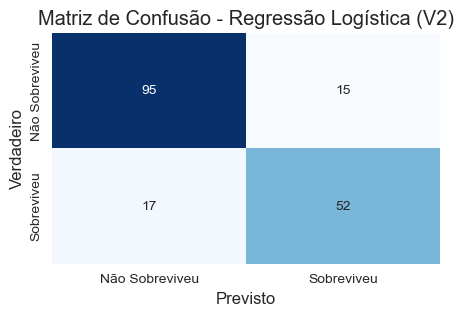


Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.85      0.86      0.86       110
    Sobreviveu (1)       0.78      0.75      0.76        69

          accuracy                           0.82       179
         macro avg       0.81      0.81      0.81       179
      weighted avg       0.82      0.82      0.82       179

--------------------------------------------------


--- Avaliando: Random Forest (V2) ---
Acurácia: 0.7933
AUC-ROC: 0.8557

Matriz de Confusão:


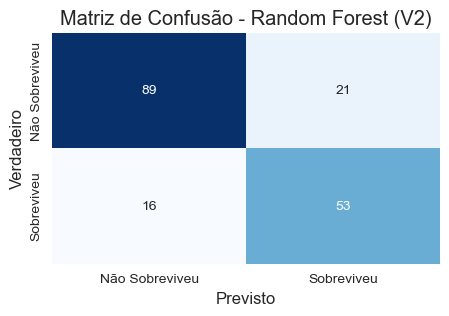


Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.85      0.81      0.83       110
    Sobreviveu (1)       0.72      0.77      0.74        69

          accuracy                           0.79       179
         macro avg       0.78      0.79      0.78       179
      weighted avg       0.80      0.79      0.79       179

--------------------------------------------------


--- Avaliando: KNN (k=5) (V2) ---
Acurácia: 0.8045
AUC-ROC: 0.7946

Matriz de Confusão:


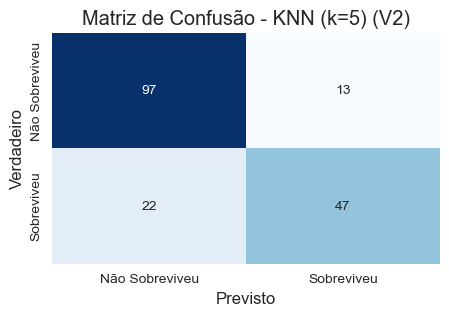


Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.82      0.88      0.85       110
    Sobreviveu (1)       0.78      0.68      0.73        69

          accuracy                           0.80       179
         macro avg       0.80      0.78      0.79       179
      weighted avg       0.80      0.80      0.80       179

--------------------------------------------------


--- Avaliando: Gaussian NB (V2) ---
Acurácia: 0.7318
AUC-ROC: 0.7588

Matriz de Confusão:


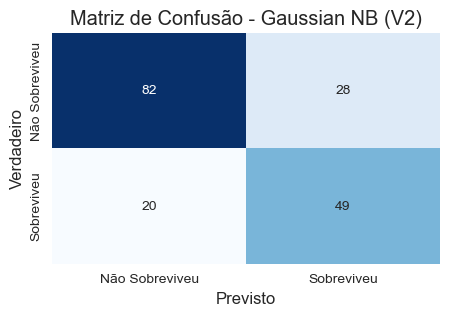


Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.80      0.75      0.77       110
    Sobreviveu (1)       0.64      0.71      0.67        69

          accuracy                           0.73       179
         macro avg       0.72      0.73      0.72       179
      weighted avg       0.74      0.73      0.73       179

--------------------------------------------------


In [34]:
if 'X_final_v2_scaled' not in globals() or 'y_final_v2' not in globals() or y_final_v2 is None:
    print("ERRO: 'X_final_v2_scaled' ou 'y_final_v2' não definidos. Verifique as Células E e F.")
else:

    ## Divisão Treino/Validação
    X_train_splt_v2, X_val_splt_v2, y_train_splt_v2, y_val_splt_v2 = train_test_split(
        X_final_v2_scaled,
        y_final_v2,
        test_size=0.2,
        random_state=42,
        stratify=y_final_v2
    )
    print("Dados divididos para treino/validação local (V2):")
    print(f"X_train_splt_v2: {X_train_splt_v2.shape}, y_train_splt_v2: {y_train_splt_v2.shape}")
    print(f"X_val_splt_v2: {X_val_splt_v2.shape}, y_val_splt_v2: {y_val_splt_v2.shape}")

    ## Modelos
    models_v2 = [
        ('Regressão Logística', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)),
        ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=5, random_state=42, class_weight='balanced')),
        ('KNN (k=5)', KNeighborsClassifier(n_neighbors=5)),
        ('Gaussian NB', GaussianNB())
    ]

    for name, model in models_v2:
        print(f"\n\n--- Avaliando: {name} (V2) ---")

        model.fit(X_train_splt_v2, y_train_splt_v2)

        y_pred = model.predict(X_val_splt_v2)
        y_proba = model.predict_proba(X_val_splt_v2)[:, 1]

        acc = accuracy_score(y_val_splt_v2, y_pred)
        auc = roc_auc_score(y_val_splt_v2, y_proba)

        print(f"Acurácia: {acc:.4f}")
        print(f"AUC-ROC: {auc:.4f}")

        print("\nMatriz de Confusão:")
        cm = confusion_matrix(y_val_splt_v2, y_pred)
        plt.figure(figsize=(5,3)) # Tamanho menor para economizar espaço
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Não Sobreviveu', 'Sobreviveu'],
                    yticklabels=['Não Sobreviveu', 'Sobreviveu'])
        plt.xlabel('Previsto')
        plt.ylabel('Verdadeiro')
        plt.title(f'Matriz de Confusão - {name} (V2)')
        plt.show()

        print("\nRelatório de Classificação:")
        print(classification_report(y_val_splt_v2, y_pred, target_names=['Não Sobreviveu (0)', 'Sobreviveu (1)']))
        print("-" * 50)

### Avaliação de Modelos com Validação Cruzada


Métricas de Validação Cruzada (5 folds) - V2:
----------------------------------------------------
Regressão Logística:
  Acurácia Média: 0.8249 (+/- 0.0307)
  AUC-ROC Médio: 0.8611 (+/- 0.0274)
---
Random Forest:
  Acurácia Média: 0.8249 (+/- 0.0144)
  AUC-ROC Médio: 0.8653 (+/- 0.0304)
---
KNN (k=5):
  Acurácia Média: 0.8159 (+/- 0.0245)
  AUC-ROC Médio: 0.8417 (+/- 0.0335)
---
Gaussian NB:
  Acurácia Média: 0.7665 (+/- 0.0222)
  AUC-ROC Médio: 0.8143 (+/- 0.0257)
---
SVC:
  Acurácia Média: 0.8193 (+/- 0.0306)
  AUC-ROC Médio: 0.8539 (+/- 0.0438)
---

Resumo dos Resultados da Validação Cruzada (V2):


,model,accuracy_mean,accuracy_std,roc_auc_mean,roc_auc_std
1,Random Forest,0.824914,0.014409,0.865344,0.030369
0,Regressão Logística,0.824933,0.030747,0.861144,0.027376
4,SVC,0.819308,0.030620,0.853890,0.043783
2,KNN (k=5),0.815931,0.024503,0.841663,0.033549
3,Gaussian NB,0.766543,0.022183,0.814292,0.025663


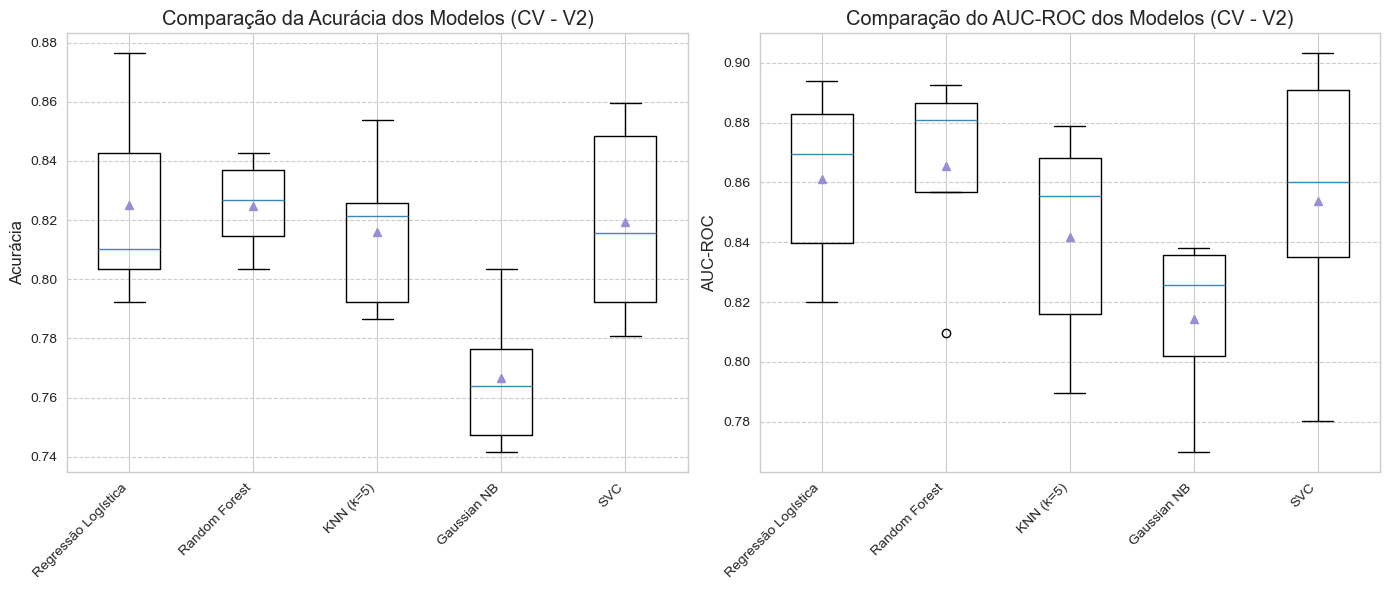

In [26]:
if 'X_final_v2_scaled' not in globals() or 'y_final_v2' not in globals() or y_final_v2 is None:
    print("ERRO: 'X_final_v2_scaled' ou 'y_final_v2' não definidos. Verifique as Células E e F.")
else:
    num_folds_v2 = 5
    kfold_v2 = KFold(n_splits=num_folds_v2, random_state=42, shuffle=True)

    log_reg_cv_v2 = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
    rf_cv_v2 = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=5, random_state=42, class_weight='balanced')
    knn_cv_v2 = KNeighborsClassifier(n_neighbors=5)
    gnb_cv_v2 = GaussianNB()
    svc_cv_v2 = SVC(probability=True, random_state=42)


    models_to_cv_v2 = [
        ('Regressão Logística', log_reg_cv_v2),
        ('Random Forest', rf_cv_v2),
        ('KNN (k=5)', knn_cv_v2),
        ('Gaussian NB', gnb_cv_v2),
        ('SVC', svc_cv_v2)
    ]

    results_list_cv_v2 = []
    names_list_cv_v2 = []

    accuracies_all_models_v2 = []
    roc_aucs_all_models_v2 = []

    print(f"\nMétricas de Validação Cruzada ({num_folds_v2} folds) - V2:")
    print("----------------------------------------------------")

    for name, model in models_to_cv_v2:
        # Acurácia
        cv_accuracy_scores = cross_val_score(model, X_final_v2_scaled, y_final_v2, cv=kfold_v2, scoring='accuracy')
        accuracies_all_models_v2.append(cv_accuracy_scores)
        # AUC-ROC
        try:
            cv_roc_auc_scores = cross_val_score(model, X_final_v2_scaled, y_final_v2, cv=kfold_v2, scoring='roc_auc')
            roc_aucs_all_models_v2.append(cv_roc_auc_scores)
        except Exception as e:
            print(f"Não foi possível calcular roc_auc para {name} via cross_val_score: {e}")
            cv_roc_auc_scores = np.array([np.nan] * num_folds_v2)
            roc_aucs_all_models_v2.append(cv_roc_auc_scores)

        results_list_cv_v2.append({
            'model': name,
            'accuracy_mean': cv_accuracy_scores.mean(),
            'accuracy_std': cv_accuracy_scores.std(),
            'roc_auc_mean': cv_roc_auc_scores.mean(),
            'roc_auc_std': cv_roc_auc_scores.std()
        })
        names_list_cv_v2.append(name)

        print(f"{name}:")
        print(f"  Acurácia Média: {cv_accuracy_scores.mean():.4f} (+/- {cv_accuracy_scores.std():.4f})")
        print(f"  AUC-ROC Médio: {cv_roc_auc_scores.mean():.4f} (+/- {cv_roc_auc_scores.std():.4f})")
        print("---")

    results_df_cv_v2 = pd.DataFrame(results_list_cv_v2)
    print("\nResumo dos Resultados da Validação Cruzada (V2):")
    display(results_df_cv_v2.sort_values(by='roc_auc_mean', ascending=False))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.boxplot(accuracies_all_models_v2, labels=names_list_cv_v2, showmeans=True)
    plt.title('Comparação da Acurácia dos Modelos (CV - V2)')
    plt.ylabel('Acurácia')
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--')

    plt.subplot(1, 2, 2)
    valid_roc_aucs_v2 = [roc_auc for roc_auc in roc_aucs_all_models_v2 if not np.all(np.isnan(roc_auc))]
    valid_names_roc_v2 = [names_list_cv_v2[i] for i, roc_auc in enumerate(roc_aucs_all_models_v2) if not np.all(np.isnan(roc_auc))]

    if valid_roc_aucs_v2:
        plt.boxplot(valid_roc_aucs_v2, labels=valid_names_roc_v2, showmeans=True)
        plt.title('Comparação do AUC-ROC dos Modelos (CV - V2)')
        plt.ylabel('AUC-ROC')
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis='y', linestyle='--')
    else:
        plt.text(0.5, 0.5, 'Nenhum AUC-ROC para plotar', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

### Ajuste de Hiperparâmetros com GridSearchCV

In [ ]:
if 'X_final_v2_scaled' not in globals() or 'y_final_v2' not in globals() or y_final_v2 is None:
    print("ERRO: 'X_final_v2_scaled' ou 'y_final_v2' não definidos.")
else:

    best_model_candidate_name = "Random Forest"
    print(f"Modelo escolhido para otimização de hiperparâmetros: {best_model_candidate_name}")

    model_to_tune = None
    param_grid = {}

    if best_model_candidate_name == "Random Forest":
        model_to_tune = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 150, 200],
            'max_depth': [5, 7, 9, 11, None],
            'min_samples_split': [2, 4, 6, 8],
            'min_samples_leaf': [2, 3, 4, 5],
            'class_weight': ['balanced', None],
            'max_features': ['sqrt', 'log2', None]
        }

    elif best_model_candidate_name == "Regressão Logística":
        model_to_tune = LogisticRegression(solver='liblinear', random_state=42, max_iter=2000)
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }

    elif best_model_candidate_name == "KNN":
        model_to_tune = KNeighborsClassifier()
        param_grid = {
            'n_neighbors': list(range(3, 16, 2)),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }

    elif best_model_candidate_name == "SVC":
        from sklearn.svm import SVC
        model_to_tune = SVC(probability=True, random_state=42)
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01, 0.1],
            'kernel': ['rbf', 'linear']
        }

    if model_to_tune is not None:
        print(f"\nIniciando GridSearchCV para {best_model_candidate_name}...")
        grid_search_v2 = GridSearchCV(
            estimator=model_to_tune,
            param_grid=param_grid,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        grid_search_v2.fit(X_final_v2_scaled, y_final_v2)

        print(f"\nGridSearchCV para {best_model_candidate_name} concluído.")
        print("Melhores hiperparâmetros encontrados:")
        print(grid_search_v2.best_params_)
        print(f"\nMelhor score AUC-ROC (CV com GridSearchCV): {grid_search_v2.best_score_:.4f}")

        best_tuned_model_v2 = grid_search_v2.best_estimator_

    else:
        print(f"Modelo '{best_model_candidate_name}' não configurado para GridSearchCV. Pulando esta etapa.")
        best_tuned_model_v2 = None

Modelo escolhido para otimização de hiperparâmetros: Random Forest

Iniciando GridSearchCV para Random Forest...
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


### Arquivo de Submissão

In [35]:
if 'best_tuned_model_v2' not in globals() or best_tuned_model_v2 is None:
    print("ERRO: 'best_tuned_model_v2' não definido ou é None. Execute a Célula I (GridSearchCV).")
elif 'X_test_final_v2_scaled' not in globals():
    print("ERRO: 'X_test_final_v2_scaled' não definido. Verifique a Célula F.")
elif 'passenger_id_test_v2' not in globals() or passenger_id_test_v2 is None:
    print("ERRO: 'passenger_id_test_v2' não definido. Verifique a Célula B.")
else:
    model_name_for_submission = best_model_candidate_name if 'best_model_candidate_name' in globals() else "ModeloOtimizado"
    print(f"Gerando previsões com o modelo otimizado: {model_name_for_submission}")

    test_predictions_v2 = best_tuned_model_v2.predict(X_test_final_v2_scaled)

    print("Previsões geradas para o conjunto de teste.")
    print(f"Número de previsões: {len(test_predictions_v2)}")

    if len(passenger_id_test_v2) == len(test_predictions_v2):
        submission_df_v2 = pd.DataFrame({
            "PassengerId": passenger_id_test_v2,
            "Survived": test_predictions_v2
        })

        submission_filename_v2 = f'submission/submission_07.csv'

        submission_df_v2.to_csv(submission_filename_v2, index=False)

        print(f"\nArquivo de submissão '{submission_filename_v2}' criado com sucesso!")
        print("Primeiras 5 linhas do arquivo de submissão (V2):")
        display(submission_df_v2.head())

        print(f"\nTotal de passageiros no arquivo de submissão: {len(submission_df_v2)}")
        print("Contagem de previsões de sobrevivência (0 = Não, 1 = Sim):")
        print(submission_df_v2['Survived'].value_counts())


Gerando previsões com o modelo otimizado: Random Forest
Previsões geradas para o conjunto de teste.
Número de previsões: 418

Arquivo de submissão 'submission/submission_07.csv' criado com sucesso!
Primeiras 5 linhas do arquivo de submissão (V2):


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1



Total de passageiros no arquivo de submissão: 418
Contagem de previsões de sobrevivência (0 = Não, 1 = Sim):
Survived
0    240
1    178
Name: count, dtype: int64
